# Segment Anything Model (SAM) Workflow with FarmVibes.AI

This notebook demonstrates how to segment Sentinel-2 imagery, using a FarmVibes.AI workflow that leverages [Segment Anything Model](https://github.com/facebookresearch/segment-anything) (SAM). 

**Note:** if you are interested in an example that runs SAM outside of FarmVibes.AI cluster, refer to the `sam_exploration.ipynb` notebook.

The notebook is divided into the following sections:

1. **Environment setup**: this section provides instructions for setting up the conda environment for FarmVibes.AI and importing the necessary libraries for the notebook. We also download and export the ONNX files required to run SAM workflows to our cluster.

2. **Workflow setup**: we define a location and time range of interest for our analysis, and build our prompt with multiple points.

3. **Running the workflow**: this section discusses the parameters of the SAM workflow and demonstrates how to run it.

4. **Visualizing the results**: finally, we visualize the results of the workflow.

We run steps 3 and 4 for a few different parameter combinations to demonstrate the effect of the parameters on the results.


## Environment setup

Before running this notebook, make sure to set up a conda environment with all the required dependencies for FarmVibes.AI.

**If you are importing the ONNX files to your cluster for the first time**, make sure the following environment is configured:

```bash
$ conda env create -f env_cpu.yml
$ conda activate segment_anything_cpu
```

**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ conda activate farmvibes-ai
```


### Importing SAM's ONNX models to the cluster

Before running SAM workflows in FarmVibes.AI, we need to add the model to our cluster. We provide a script that downloads the original weights from the [official repository](https://github.com/facebookresearch/segment-anything) and separately converts the image encoder and prompt encoder + mask decoder to ONNX format. The script also adds the ONNX models to our cluster, allowing them to be used in workflows.

To run the script, execute the following command:

```bash
$ python scripts/export_sam_models.py --models <model_types>
```

where `<model_types>` is a list of model types to be exported (`vit_b`, `vit_l`, `vit_h`). For example, to export all three ViT backbones, run:

```bash
$ python scripts/export_sam_models.py --models vit_b vit_l vit_h
```

In this notebook, we will export the `vit_b` model:

In [ ]:
! python ../../scripts/export_sam_models.py --models vit_b

### Imports

In [1]:
import sys

import matplotlib.pyplot as plt
from datetime import datetime
import notebook_lib.utils as utils
from shapely import geometry as shpg
import geopandas as gpd
import rasterio
import yaml
import os

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid

# Add shared notebook library to path
sys.path.append("../")
from shared_nb_lib.plot import lw_plot, transparent_cmap
from shared_nb_lib.raster import read_raster, s2_to_img

### Storage Path

To feed the prompts to the workflow, we will create a GeoDataFrame and save it in the FarmVibes.AI cache directory. During setup, FarmVibes.AI stores the path to the cache directory in `~/.config/farmvibes-ai/storage` (or `{XDG_CONFIG_HOME}/farmvibes-ai/storage` if you had a `XDG_CONFIG_HOME` environment variable set).

Make sure the `storage_dir` variable below points to the same path as the one in the storage file.

In [2]:
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config/farmvibes-ai"))
storage_config_path = os.path.join(config_dir, "storage")
try:
    with open(storage_config_path) as f:
        storage_dir = f.read().strip()
    print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")
except FileNotFoundError:
    print(f"Could not find FarmVibes.AI cache directory at '{storage_config_path}'! Please assign the correct value to `storage_dir`")

Cache directory set to '/datadrive' by reading '/home/azureuser/.config/farmvibes-ai/storage'


## Workflow setup

The `ml/segment_anything/point_prompt_sam` workflow takes a Sentinel-2 raster, an input geometry of the Region of Interest (RoI), and an `ExternalReferenceList` pointing to a GeoDataFrame containing the points used as prompts, their labels (`foreground` or `background`) and associated prompt ids (indicating the prompt to which a point belongs), and returns a CategoricalRaster with the segmentation results (one per prompt).


Before inspecting how the workflow is defined, let's instantiate our client:


In [ ]:
client = get_default_vibe_client()

The definition of the `ml/segment_anything/point_prompt_sam` workflow can be inspected with:

In [3]:

client.document_workflow("ml/segment_anything/point_prompt_sam")

Workflow: ml/segment_anything/point_prompt_sam

Description:

Runs Segment Anything Model over a Sentinel-2 raster with points as prompts. This workflow      
    splits the input raster into chips of 1024x1024 pixels with an overlap defined by               
    `spatial_overlap`. Chips intersecting with points in the prompt are processed by SAM's image    
    encoder, followed by prompt encoder and mask decoder.

Sources:

- input_raster (vibe_core.data.sentinel.Sentinel2Raster): Sentinel-2 raster to be segmented.

- input_geometry (vibe_core.data.core_types.DataVibe): Geometry of interest for the             
    segmentation.

- point_prompt (List[vibe_core.data.core_types.ExternalReferenceList]): Point prompts as        
    ExternalReferences to GeoJSON with point coordinates, label (foreground/background) and prompt  
    id (in case, the raster contains multiple entities that should be segmented in a single workflow
    run).

Sinks:

- segmentation_mask (vibe_core.data.rasters.CategoricalRaster): Output segmentation mask.

Parameters:

- model_type (default: vit_b): SAM's image encoder backbone architecture, among 'vit_h',        
    'vit_l', or 'vit_b'.

- spatial_overlap (default: 0.5): Spatial overlap between chips in the range of [0.0, 1.0).

Tasks:

- ingest_points: Adds user geometries into the cluster storage, allowing for them to be used on 
    workflows.

- sam: Runs SAM over the input raster with points as prompts.

The workflow has two parameters:

- `model_type`: defines the backbone architecture for SAM's image encoder, among `vit_b`, `vit_l`, and `vit_h`. The default value is `vit_b`.
- `spatial_overlap`: the input raster is split into chips of size 1024x1024 pixels. This parameter defines the spatial overlap between chips in the segmentation process. The default value is 0.5, meaning that the chips will overlap by 50%.

In this notebook, we will use the custom workflow defined by `s2_segmentation.yaml` file. It first downloads Sentinel-2 data with the `data_ingestion/sentinel2/preprocess_s2` workflow, and feed the raster to the `ml/segment_anything/point_prompt_sam` workflow.

The `s2_segmentation.yaml` workflow is defined as follows:

In [4]:
! cat s2_segmentation.yaml

name: s2_sam_point_prompt
sources:
  user_input:
    - s2.user_input
    - sam.input_geometry
  points:
    - sam.point_prompt
sinks:
  s2_raster: s2.raster
  segmentation_mask: sam.segmentation_mask
parameters:
  model_type: vit_b
  spatial_overlap: 0.5
tasks:
  s2:
    workflow: data_ingestion/sentinel2/preprocess_s2
  sam:
    workflow: ml/segment_anything/point_prompt_sam
    parameters:
        model_type: "@from(model_type)"
        spatial_overlap: "@from(spatial_overlap)"
edges:
  - origin: s2.raster
    destination:
      - sam.input_raster


Let's define a location and time range to download data from. In this example, we select a small region around a defined latitude/longitude and a time range of a few days.

In [5]:
with open("s2_segmentation.yaml") as f:
    wf_dict = yaml.safe_load(f)

geom = shpg.Point(-119.21896203939313, 46.44578909859286).buffer(.07, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

roi_time_range = DataVibe(id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[])

We will also define a prompt with multiple points. The prompt is defined as a GeoDataFrame with the following columns:
- `geometry`: the list of points that define the prompts.
- `label`: the label of each point, either 1 (the entity of interest or `foreground`) or 0 (not part of the entity of interest, or `background`).
- `prompt_id`: the id of the prompt to which each point belongs. Each prompt is defined as a set of points with the same `prompt_id`. The resulting segmentation mask will have a number of channels equal to the number of unique `prompt_id` values.

In this initial example, we will define 3 prompts. The first prompt will consist on four points across a river, whereas the remaining two prompts will be single-point prompts on two crop fields. The `prompt_id` values will be 0, 1, and 2, respectively. For now, the `label` values will be 1 for all points as we will not have 'background' points. 

In [6]:
point_list = [
        # Prompt 0 - River points
        shpg.Point(-119.26547198690993, 46.451875370803414), 
        shpg.Point(-119.26336098664864, 46.4655760422024), 
        shpg.Point(-119.26312845986224, 46.43954823602075),
        shpg.Point(-119.2608366093817, 46.43542519065661),
        shpg.Point(-119.26424972761195, 46.414014420571874),
        shpg.Point(-119.26738020466517, 46.50954827923965),
        # Prompt 1 - Crop field point
        shpg.Point(-119.20314156716711, 46.450779271211765),
        # Prompt 2 - Another crop field point
        shpg.Point(-119.2075790583149, 46.43965317746578),
    ]
prompt_ids = [0, 0, 0, 0, 0, 0, 1, 2]
labels = [1, 1, 1, 1, 1, 1, 1, 1]

filepath, gdf, fid = utils.create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
        id=f"geo_{fid}", 
        time_range=time_range, 
        geometry=shpg.mapping(geom), 
        assets=[], 
        urls=[filepath]
    )

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Running the workflow

In [7]:
run = client.run(wf_dict, "SAM segmentation", input_data={"user_input": roi_time_range, "points": geom_collection})
run.monitor()

Output()

## Visualizing the results

The output of the segmentation is a mask with the same size as the input RoI, with each channels corresponding to a prompt. The values of the mask are 0 (background) or 1 (foreground). We can visualize the mask by plotting the mask for each prompt, as well as the foreground (green) and background (red) points used as prompts.

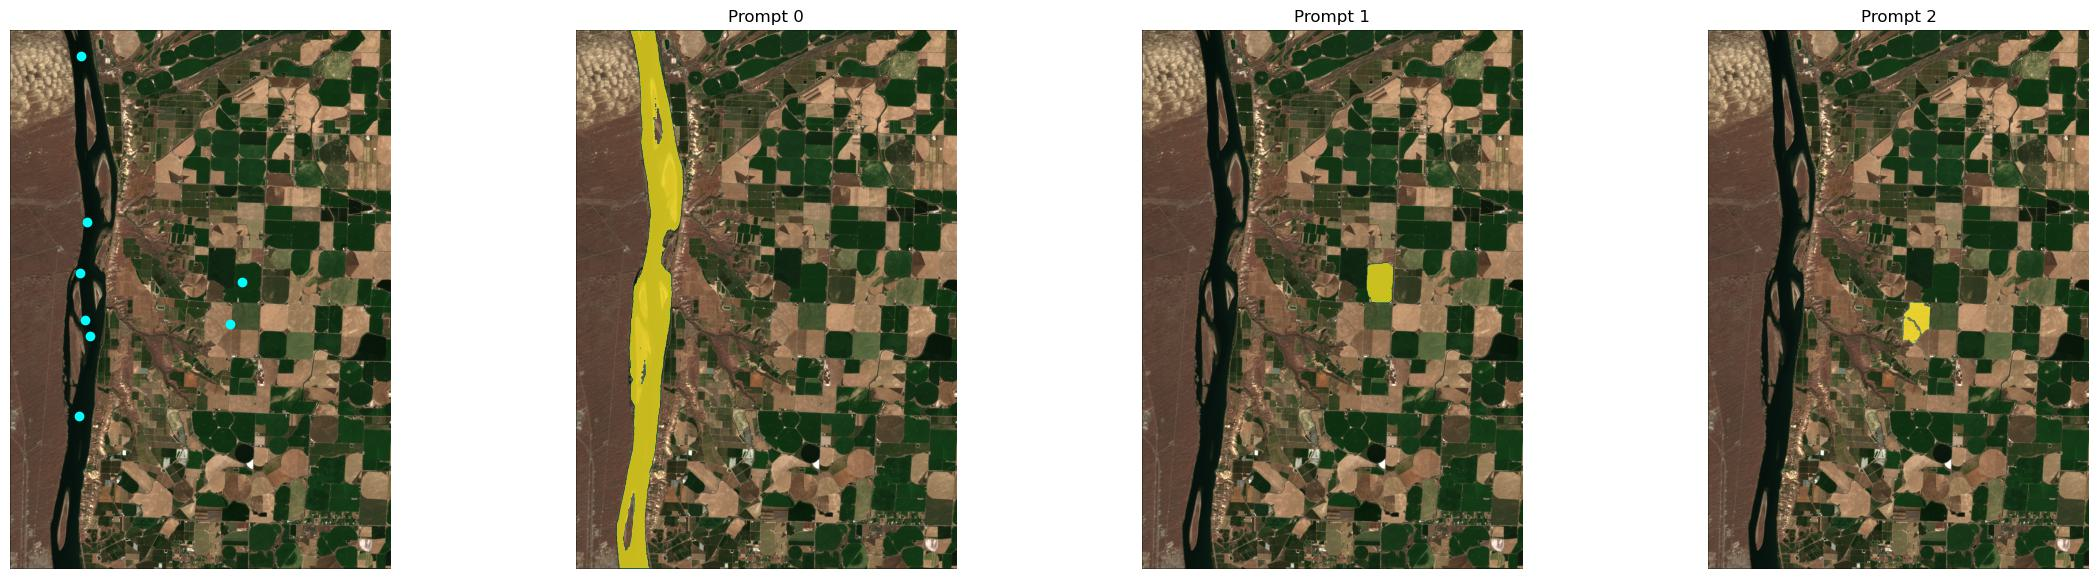

In [8]:
# Reprojecting the raster and points to the same CRS
with rasterio.open(run.output["s2_raster"][0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope
    shpg_points = list(gdf.to_crs(src.crs)["geometry"])

# Reading the raster
ar, transform = read_raster(run.output["s2_raster"][0], projected_geometry = proj_geom)
img = s2_to_img(ar)

# Reading the segmentation mask
mask_ar, _ = read_raster(run.output["segmentation_mask"][0], projected_geometry = proj_geom)

# Transforming the points to pixel coordinates for visualization
ps = [~transform * (shpg_p.x, shpg_p.y) for shpg_p in shpg_points]
foreground_ps = [p for p, l in zip(ps, labels) if l == 1]
background_ps = [p for p, l in zip(ps, labels) if l == 0]

# Visualizing the results
plt.figure(figsize=(7 * (1 + mask_ar.shape[0]), 7))
plt.subplot(1, (1 + mask_ar.shape[0]), 1)
plt.imshow(img)
plt.scatter([p[0] for p in foreground_ps], [p[1] for p in foreground_ps], color="cyan")
plt.scatter([p[0] for p in background_ps], [p[1] for p in background_ps], color="red")
plt.axis("off")

for i in range(mask_ar.shape[0]):
    plt.subplot(1, (1 + mask_ar.shape[0]), 2 + i)
    plt.imshow(img)
    plt.imshow(mask_ar[i], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title(f"Prompt {i}")
    plt.axis("off")
lw_plot()

As we can see, the segmentation is not perfect, but it is able to identify the river and the crop fields. Even though the fields are well segmented, the model has more difficulty when segmenting the river. Let's add a few 'background' points in the prompt to remove the small islands in the river.

In [9]:
point_list = [
        # Initial prompt - Foregound river points
        shpg.Point(-119.26547198690993, 46.451875370803414), 
        shpg.Point(-119.26336098664864, 46.4655760422024), 
        shpg.Point(-119.26312845986224, 46.43954823602075),
        shpg.Point(-119.2608366093817, 46.43542519065661),
        shpg.Point(-119.26424972761195, 46.414014420571874),
        shpg.Point(-119.26738020466517, 46.50954827923965),
        # Background island points
        shpg.Point(-119.2629152042414, 46.48935759242608),
        shpg.Point(-119.2575570755061, 46.47705948718639),
        shpg.Point(-119.26655313644285, 46.44515072631643),
        shpg.Point(-119.25842992347287, 46.446605588183004), 
        shpg.Point(-119.26701259696175, 46.43008409514595),
        shpg.Point(-119.27016443733498, 46.38451765944581),

    ]
prompt_ids = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

filepath, gdf, fid = utils.create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
        id=f"geo_{fid}", 
        time_range=time_range, 
        geometry=shpg.mapping(geom), 
        assets=[], 
        urls=[filepath]
    )

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


With those defined, we can now run the workflow once again:

In [10]:
run = client.run(wf_dict, "River segmentation with background points", input_data={"user_input": roi_time_range, "points": geom_collection})
run.monitor()

Output()

And visualize the results:

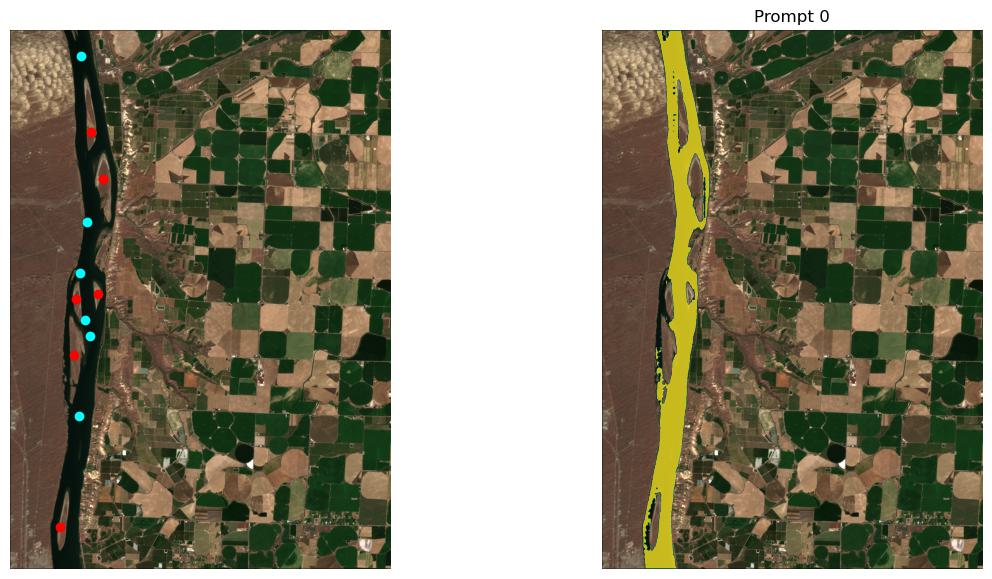

In [11]:
# Reprojecting the raster and points to the same CRS
with rasterio.open(run.output["s2_raster"][0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope
    shpg_points = list(gdf.to_crs(src.crs)["geometry"])

# Reading the raster
ar, transform = read_raster(run.output["s2_raster"][0], projected_geometry = proj_geom)
img = s2_to_img(ar)

# Reading the segmentation mask
mask_ar, _ = read_raster(run.output["segmentation_mask"][0], projected_geometry = proj_geom)

# Transforming the points to pixel coordinates for visualization
ps = [~transform * (shpg_p.x, shpg_p.y) for shpg_p in shpg_points]
foreground_ps = [p for p, l in zip(ps, labels) if l == 1]
background_ps = [p for p, l in zip(ps, labels) if l == 0]

# Visualizing the results
plt.figure(figsize=(7 * (1 + mask_ar.shape[0]), 7))
plt.subplot(1, (1 + mask_ar.shape[0]), 1)
plt.imshow(img)
plt.scatter([p[0] for p in foreground_ps], [p[1] for p in foreground_ps], color="cyan")
plt.scatter([p[0] for p in background_ps], [p[1] for p in background_ps], color="red")
plt.axis("off")

for i in range(mask_ar.shape[0]):
    plt.subplot(1, (1 + mask_ar.shape[0]), 2 + i)
    plt.imshow(img)
    plt.imshow(mask_ar[i], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title(f"Prompt {i}")
    plt.axis("off")
lw_plot()